In [1]:
!wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip


--2025-06-21 20:07:53--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  14.2MB/s    in 0.3s    

2025-06-21 20:07:54 (14.2 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.ba

In [2]:
import pandas as pd


ratings = pd.read_csv("ml-100k/u.data", sep="\t", names=["user_id", "movie_id", "rating", "timestamp"])
ratings.drop("timestamp", axis=1, inplace=True)


movies = pd.read_csv("ml-100k/u.item", sep="|", encoding='latin-1', header=None, usecols=[0, 1], names=["movie_id", "title"])


df = pd.merge(ratings, movies, on="movie_id")
df.head()


,user_id,movie_id,rating,title
0,196,242,3,Kolya (1996)
1,186,302,3,L.A. Confidential (1997)
2,22,377,1,Heavyweights (1994)
3,244,51,2,Legends of the Fall (1994)
4,166,346,1,Jackie Brown (1997)


In [3]:
movie_matrix = df.pivot_table(index='user_id', columns='title', values='rating')
movie_matrix.head()


title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN


In [4]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Calculate similarity between movies (item-based)
movie_similarity = cosine_similarity(movie_matrix.T.fillna(0))
movie_similarity_df = pd.DataFrame(movie_similarity, index=movie_matrix.columns, columns=movie_matrix.columns)

# Example: Display the most similar movies to a specific movie
def recommend_movies(movie_name, n=5):
    if movie_name not in movie_similarity_df:
        return f" The movie '{movie_name}' is not found in the data."
    sim_scores = movie_similarity_df[movie_name]
    sim_scores = sim_scores.drop(labels=[movie_name])  # Exclude the movie itself
    return sim_scores.sort_values(ascending=False).head(n)

recommend_movies("Star Wars (1977)")


,Star Wars (1977)
title,
Return of the Jedi (1983),0.884476
Raiders of the Lost Ark (1981),0.764885
"Empire Strikes Back, The (1980)",0.749819
Toy Story (1995),0.734572
"Godfather, The (1972)",0.697332


In [5]:
def recommend_for_user(user_id, n=5):
    user_ratings = movie_matrix.loc[user_id].dropna()
    sim_scores = pd.Series(dtype='float64')

    for movie, rating in user_ratings.items():
        similar_movies = movie_similarity_df[movie] * (rating - 2.5)  # Weighting
        sim_scores = sim_scores.add(similar_movies, fill_value=0)

    sim_scores = sim_scores.drop(user_ratings.index, errors='ignore')  # Exclude movies already watched
    return sim_scores.sort_values(ascending=False).head(n)

recommend_for_user(5)


,0
title,
"Terminator, The (1984)",44.197533
Pulp Fiction (1994),42.930310
Terminator 2: Judgment Day (1991),42.542520
Groundhog Day (1993),41.519037
Brazil (1985),41.112345


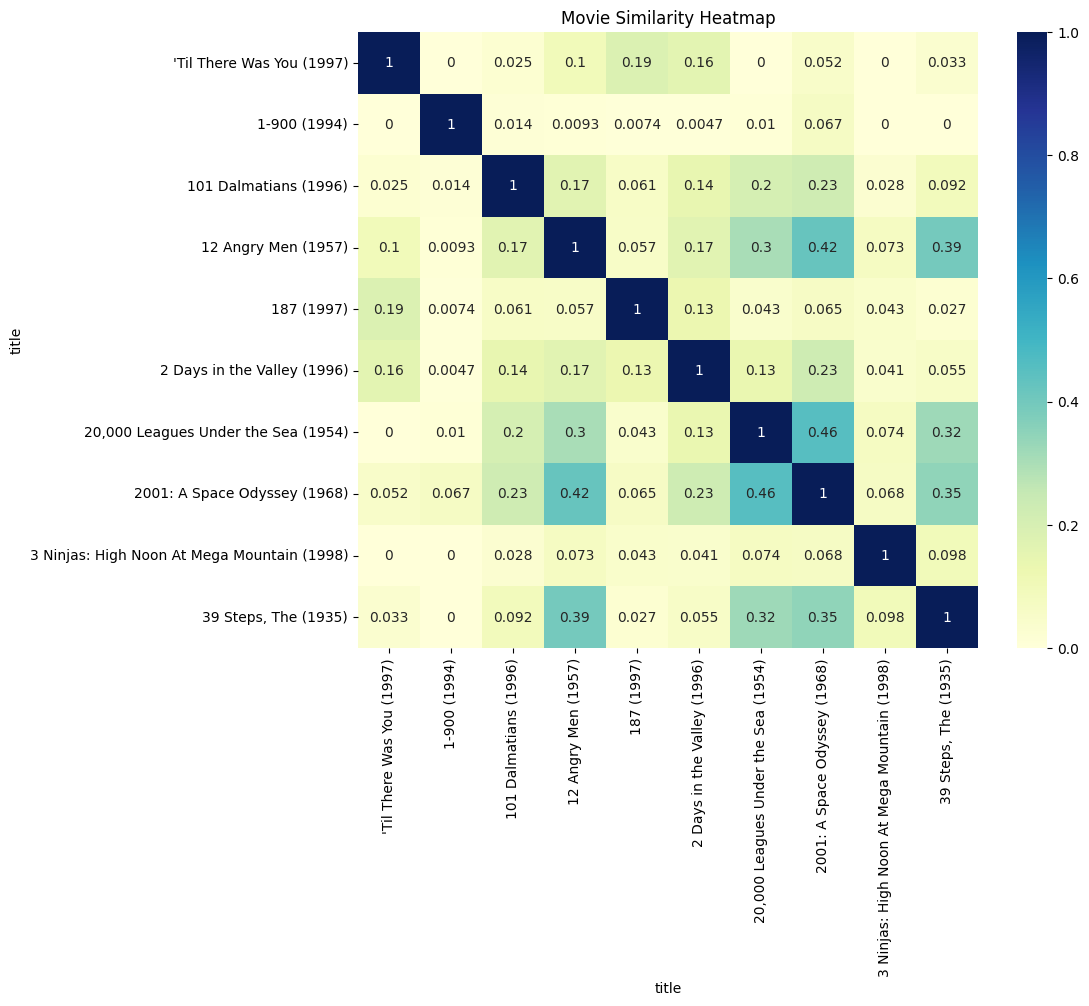

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Display similarity between the first 10 movies only
subset = movie_similarity_df.iloc[:10, :10]
plt.figure(figsize=(10, 8))
sns.heatmap(subset, annot=True, cmap="YlGnBu", xticklabels=True, yticklabels=True)
plt.title("Movie Similarity Heatmap")
plt.show()


In [8]:
import pickle

# Save the similarity matrix to a file
with open("item_similarity.pkl", "wb") as f:
    pickle.dump(movie_similarity_df, f)

print(" The matrix has been saved to item_similarity.pkl")


 The matrix has been saved to item_similarity.pkl


In [9]:
with open("item_similarity.pkl", "rb") as f:
    loaded_similarity_df = pickle.load(f)

loaded_similarity_df["Star Wars (1977)"].sort_values(ascending=False).head(5)


,Star Wars (1977)
title,
Star Wars (1977),1.000000
Return of the Jedi (1983),0.884476
Raiders of the Lost Ark (1981),0.764885
"Empire Strikes Back, The (1980)",0.749819
Toy Story (1995),0.734572
